# Akbank DL ANN Projesi: Balık Türü Sınıflandırma

Bu proje, derin öğrenme kullanarak farklı balık türlerini sınıflandıran bir model geliştirmeyi amaçlamaktadır. **TensorFlow** ve **Keras** kütüphaneleri kullanılarak yapay sinir ağı (ANN) modeli eğitilmiş, modelin performansı değerlendirilmiştir.


##  Veri Seti Hazırlığı

Balık türlerini içeren veri seti, görüntüler ve etiketler şeklinde organize edilmiştir. Görüntü yolları ve etiketler `DataFrame` yapısına dönüştürülmüş ve eğitim/test ayrımı yapılmıştır. Ayrıca, veri görselleştirmesi ile her balık türünden örnek görüntüler gösterilmiştir.


##  Model Mimarisi

Model, giriş katmanı olarak düzleştirme (flattening), ardından üç tam bağlı (dense) katmandan oluşur. Aktivasyon fonksiyonu olarak **ReLU** kullanılmış ve her katmanda **BatchNormalization** ile modelin genelleme yeteneği artırılmıştır. Ayrıca, aşırı öğrenmeyi önlemek için **Dropout** katmanları eklenmiştir. Çıkış katmanında **softmax** aktivasyonu kullanılarak çok sınıflı sınıflandırma yapılmıştır.


## Model Eğitimi ve Performansı

Model, 20 epoch boyunca eğitim verisi ile eğitilmiş ve doğrulama seti ile değerlendirilmiştir. **Adam** optimizasyon algoritması ile eğitim yapılmıştır. Performans değerlendirmesinde doğruluk (accuracy) ve kayıp (loss) değerleri kullanılmış, eğitim sürecindeki başarı grafiklerle gösterilmiştir.

Erken durdurma ve öğrenme oranı azaltma callback'leri kullanılarak model performansı optimize edilmiştir.


# 1-Kütüphaneler

TensorFlow, Keras, Pandas, Numpy gibi derin öğrenme ve veri işleme kütüphaneleri projede kullanılmaktadır. Ek olarak, eğitim verilerinin görüntülenmesi ve değerlendirilmesi için Matplotlib ve Seaborn kütüphaneleri kullanılmaktadır.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import preprocess_input

import warnings
warnings.filterwarnings('ignore')

# **2-Veri Önişleme**

Verimizi yüklerken, farklı balık türlerini veya kategorilerini belirlemek için öncelikle bir 'classes' dizini oluşturuyoruz. Ardından, A Large Scale Fish veri setindeki tüm PNG görüntülerini tarayıp, her bir görüntünün dosya yolunu ve ait olduğu balık türünü (etiketini) bir DataFrame’de topluyoruz. Bu sayede, her görüntü için etiket bilgisi elde etmiş oluyoruz.*

In [2]:
# Veri seti dizinini tanımlıyoruz
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

# Balık türlerini listeliyoruz
classes = [i for i in os.listdir(fish_dir) if '.' not in i]
classes

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

In [3]:
# Görüntü yolları ve etiketler için boş listeler oluşturuyoruz
label = []
path = []

# Veri setinden bilgileri toplamak için yazdığımız kod
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1]== '.png':
             if dir_name.split()[-1] != 'GT':
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name, filename))

# Toplanan verileri DataFrame'e dönüştürüyoruz
data = pd.DataFrame(columns=['path', 'label'])
data['path'] = path
data['label'] = label

# Sonuçları gösteriyoruz
print("\nToplam görüntü sayısı:", len(data))
print("\nHer türden kaç görüntü var:")
print(data['label'].value_counts())
            


Toplam görüntü sayısı: 9000

Her türden kaç görüntü var:
label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64


# 3- Veri Analizi(EDA)

In [4]:
print("Veri setinin boyutu:", data.shape)
print("\nSütun bilgileri:")
data.info()

print("\nİlk birkaç örnek:")
print(data.head())

print("\nBalık türü sayısı:", data['label'].nunique())

Veri setinin boyutu: (9000, 2)

Sütun bilgileri:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB

İlk birkaç örnek:
                                                path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel

Balık türü sayısı: 9


## Veri Setinden Görüntü Örnekleri

Her balık türünden bir örnek görüntü, matplotlib kullanılarak görselleştirilmektedir. Bu işlem veri setinin çeşitliliğini gözlemlememize yardımcı olur.


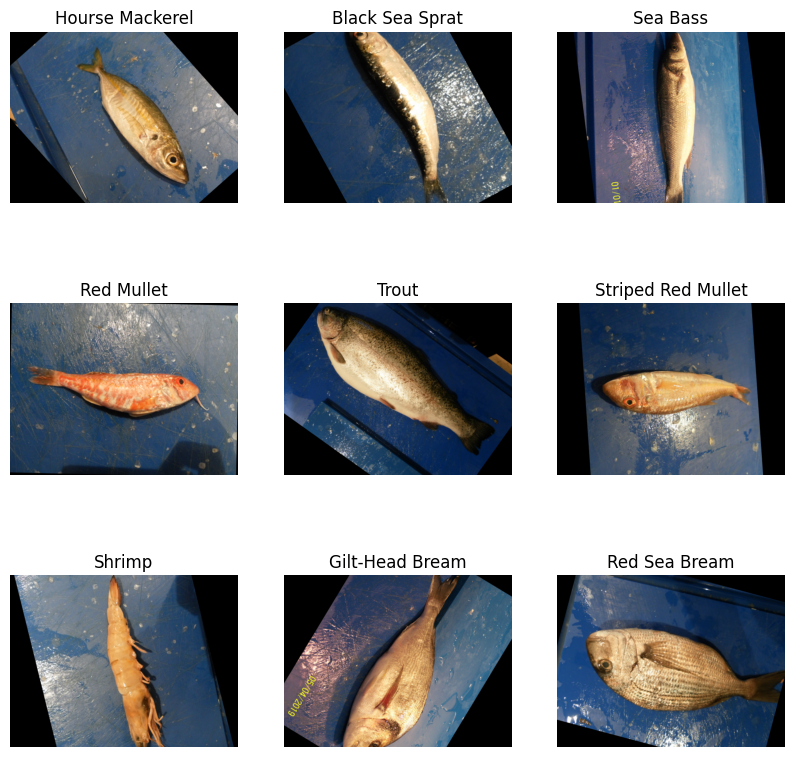

In [5]:
# Her Sınıftan(Balık Türünden) Görüntü Örnekleri Alıyoruz
cn = 0
plt.figure(figsize=(10,10))
for unique_label in data['label'].unique():
    plt.subplot(3, 3, cn+1)
    plt.imshow(plt.imread(data[data['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    cn+=1
plt.show()

# 4-Veri Yükleyicileri ve Veri Akışlarını Oluşturma

In [6]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)

In [7]:
train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Veri akışlarını oluşturalım
train_images = train_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='path',
    y_col='label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='path',
    y_col='label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_data,
    x_col='path',
    y_col='label',
    target_size=(128,128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [8]:
print("Sınıf İndeksleri:")
train_images.class_indices

Sınıf İndeksleri:


{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

# 5-ANN(Yapay Sinir Ağları) Modelimizi Oluşturuyoruz

In [9]:
model = Sequential([
    
    #Giriş katmanı
    Flatten(input_shape=(128, 128, 3)),
    
    # 1.Katman
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    # 2.Katman
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    # 3.Katman
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    # Çıkış Katmanı
    Dense(len(train_images.class_indices), activation='softmax')
    
])

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,335,305 (96.65 MB)

 Trainable params: 25,333,513 (96.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [10]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # val_loss yerine val_accuracy kullanıyoruz
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',  # val_loss yerine val_accuracy kullanıyoruz
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

# 6-Modelimizi Eğitiyoruz

In [11]:
history = model.fit(
    train_images,
    epochs=20,
    validation_data=val_images,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 169s 896ms/step - accuracy: 0.3581 - loss: 1.9554 - val_accuracy: 0.6181 - val_loss: 1.1084 - learning_rate: 0.0010
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 109s 592ms/step - accuracy: 0.6503 - loss: 1.0220 - val_accuracy: 0.7910 - val_loss: 0.6665 - learning_rate: 0.0010
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 109s 588ms/step - accuracy: 0.7798 - loss: 0.6260 - val_accuracy: 0.8549 - val_loss: 0.4435 - learning_rate: 0.0010
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 142s 589ms/step - accuracy: 0.8431 - loss: 0.4504 - val_accuracy: 0.8674 - val_loss: 0.4549 - learning_rate: 0.0010
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 109s 588ms/step - accuracy: 0.8821 - loss: 0.3439 - val_accuracy: 0.8819 - val_loss: 0.4992 - learning_rate: 0.0010
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 109s 589ms/step - accuracy: 0.9131 - loss: 0.2605 - val_accuracy: 0.8458 - val_loss: 0.6129 - learning_rate: 0.0010
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 110s 598ms/step - accura

In [12]:
# Modelimizi Değerlendiriyoruz

test_loss, test_accuracy = model.evaluate(test_images)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 34s 602ms/step - accuracy: 0.9305 - loss: 0.5959
Test Loss: 1.1002
Test Accuracy: 0.9400


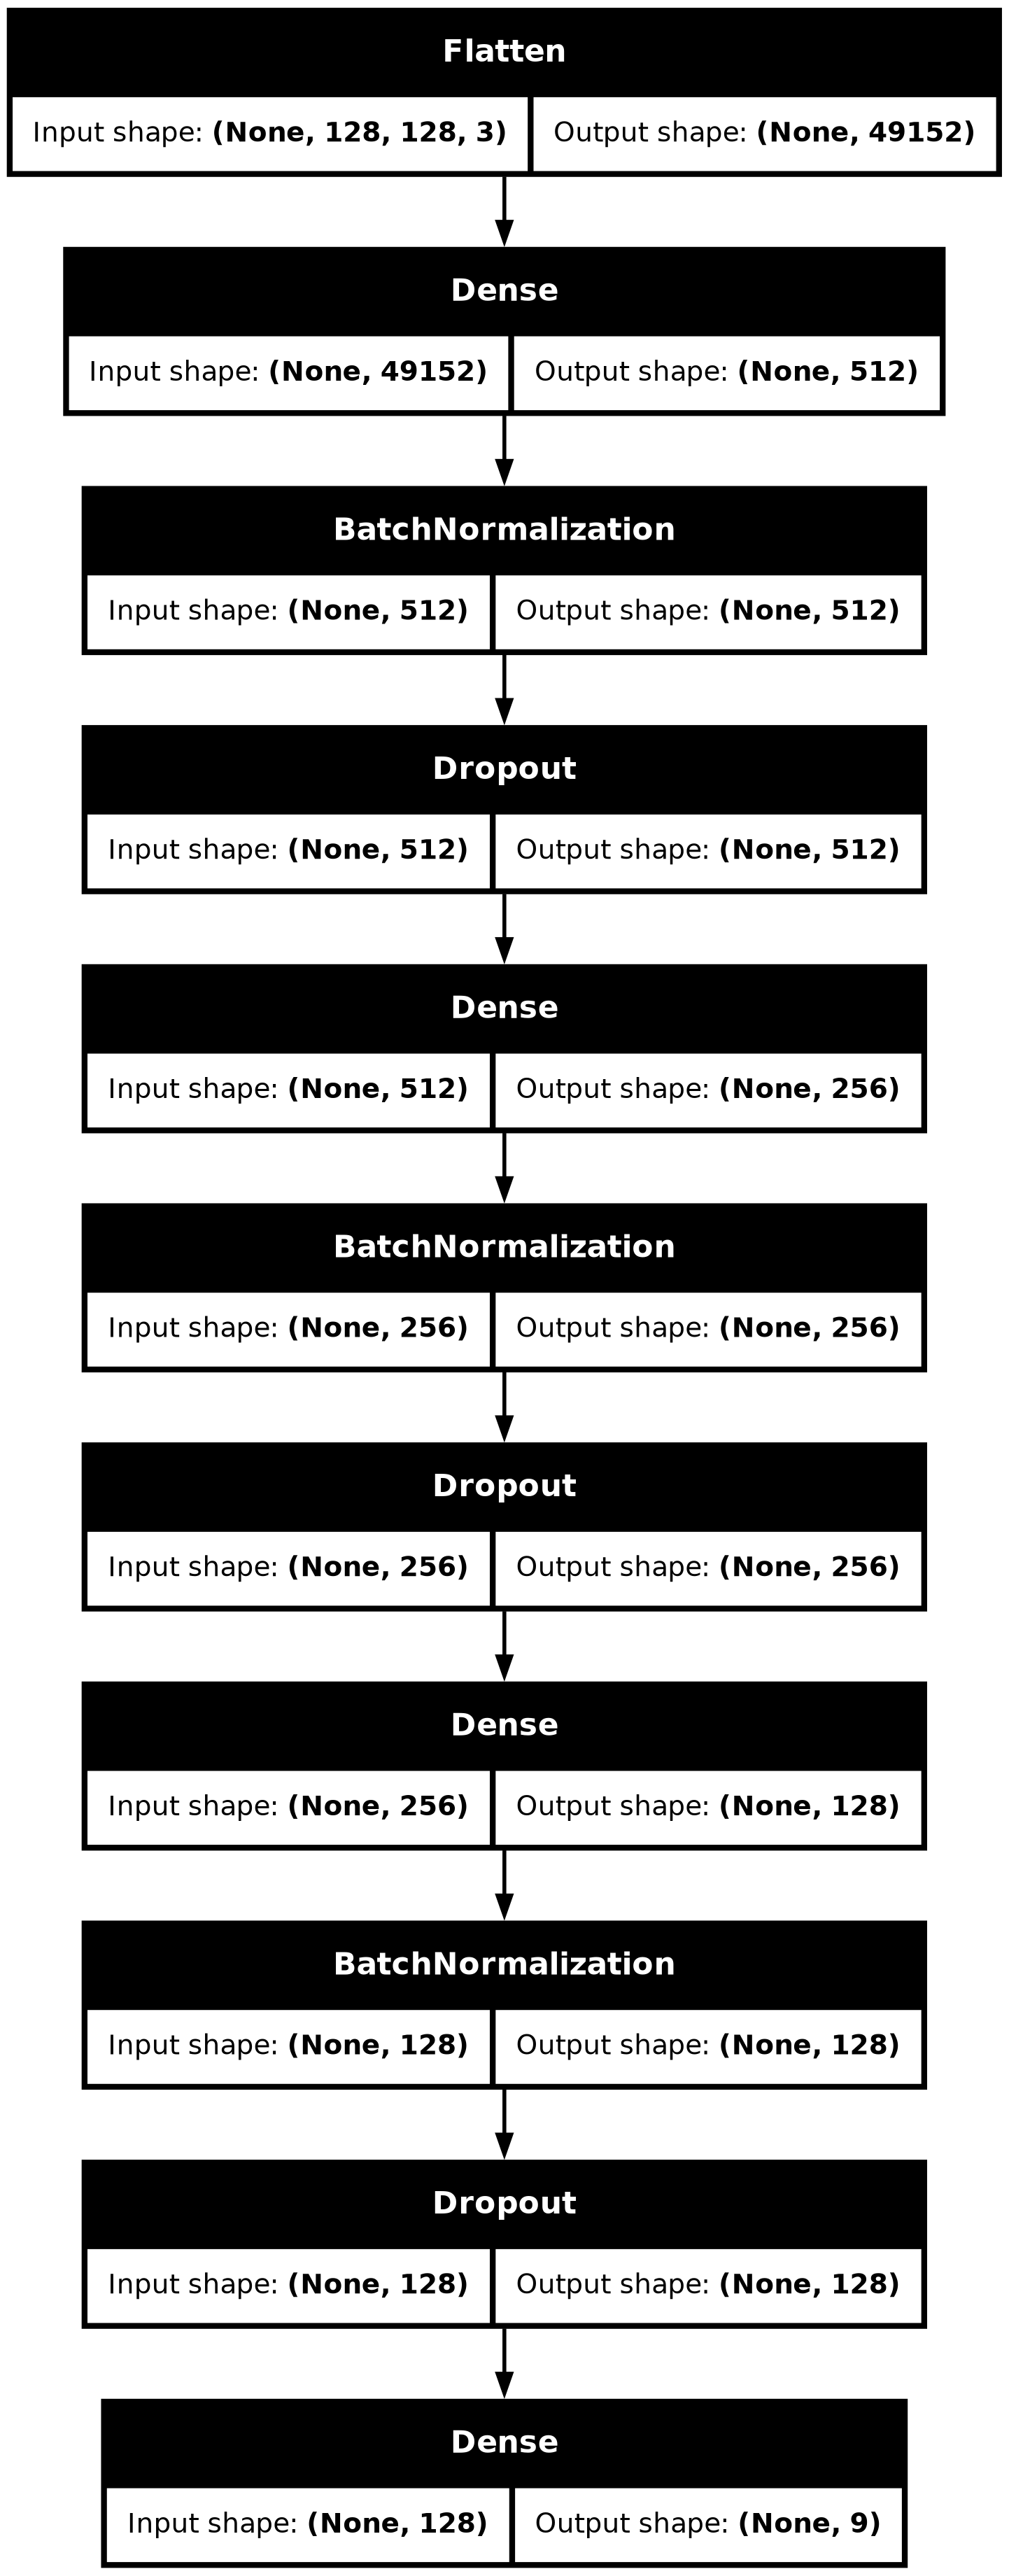

In [13]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes = True)

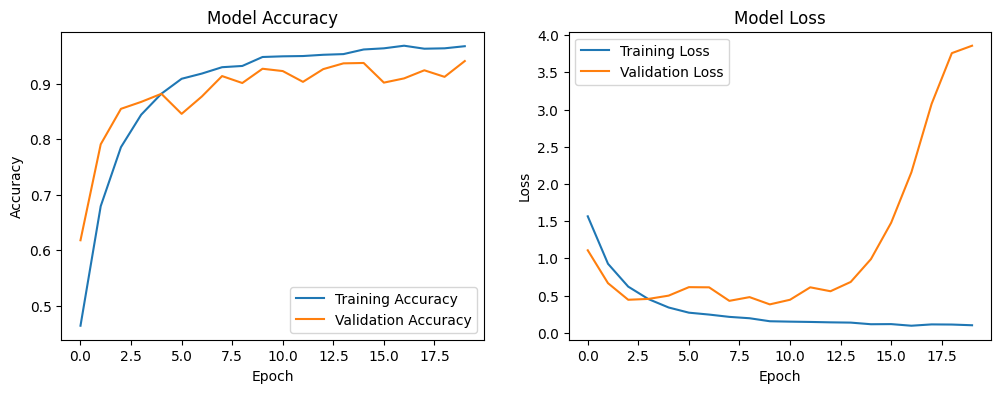

In [14]:
# Eğitimin grafiklerle gösterilmesi
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 7-Model Tahmin Fonksiyonları ve Tahminleri¶

In [15]:
# Test verilerinde tahminler yapmak için

predictions = model.predict(test_images, steps=len(test_images))
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_images.classes

57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 374ms/step


In [16]:
class_labels = list(test_images.class_indices.keys())

In [17]:
# Tahmin Dataframe

predict_data = pd.DataFrame({
    'label': [class_labels[i] for i in true_classes],
    'pred': [class_labels[i] for i in predicted_classes]
})

In [18]:
# Doğruluk Skoru

print(f"Accuracy Score: {accuracy_score(predict_data['label'], predict_data['pred'])}")

Accuracy Score: 0.94


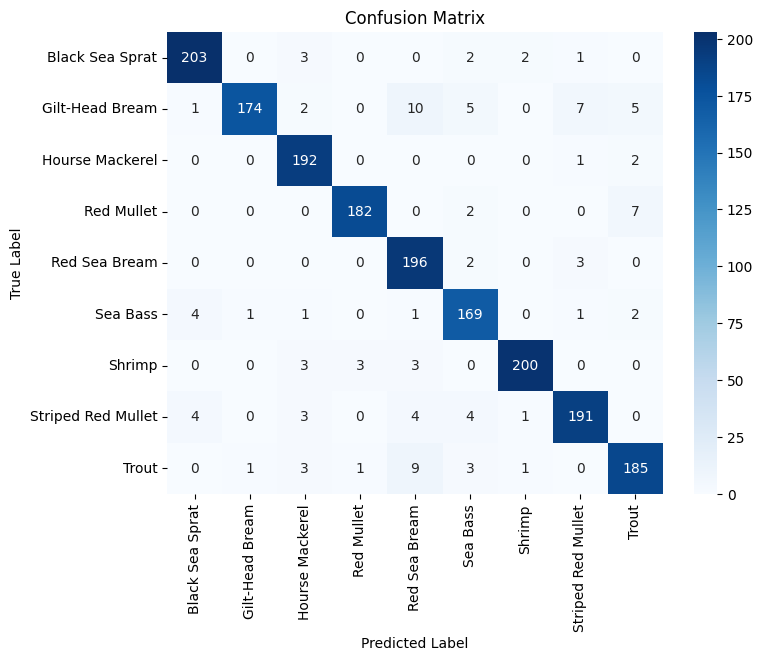

In [19]:
# Karmaşıklık Matrisi Çizelim

plt.figure(figsize=(8,6))
sns.heatmap(
    confusion_matrix(predict_data['label'], predict_data['pred']),
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 8-Tahmin Görselleştirmesi 

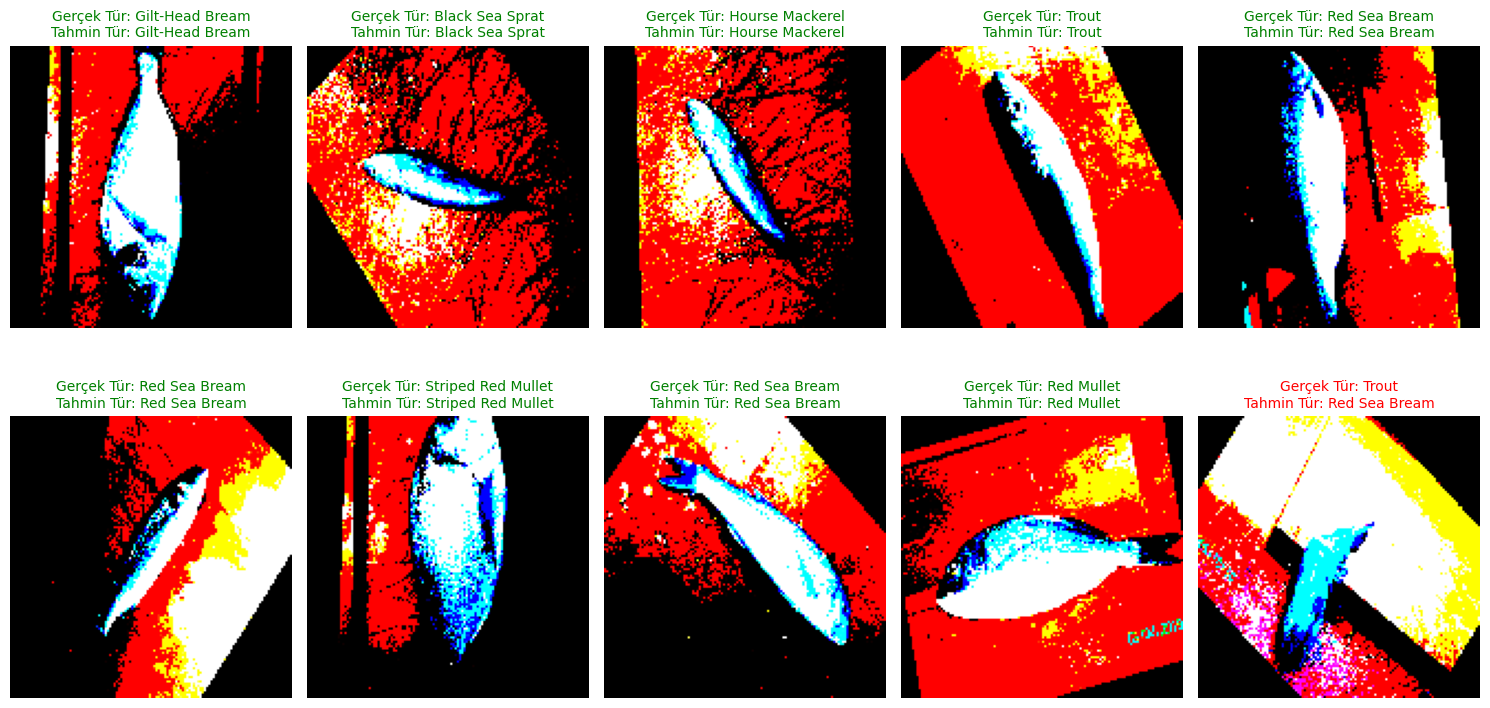

In [20]:
def plot_predictions(test_images, predictions, true_classes, num_samples=10):
   
   class_names = list(test_images.class_indices.keys())
   
   test_images.reset()
   
   # Rastgele örnek seçiyoruz

   plt.figure(figsize=(15, 8))
   
   for i in range(num_samples):
       
       img_batch, label_batch = next(test_images)
       img = img_batch[0]  # Batch'in ilk görüntüsü
       
       
       plt.subplot(2, 5, i + 1)
       
       
       plt.imshow(img)
       
       
       predicted_class = class_names[np.argmax(predictions[i])]
       true_class = class_names[true_classes[i]]
       
       
       color = 'green' if predicted_class == true_class else 'red'
       
       
       plt.title(f'Gerçek Tür: {true_class}\nTahmin Tür: {predicted_class}', 
                color=color,
                fontsize=10)
       
       plt.axis('off')
   
   plt.tight_layout()
   plt.show()


plot_predictions(test_images, predictions, true_classes)

## Sonuçlar ve Değerlendirme

Model, test verisi üzerinde %94.38 doğruluk oranı ile başarılı bir şekilde çalışmıştır. **Confusion Matrix** ve başarı grafikleri ile modelin performansı görselleştirilmiştir. Yanlış tahmin edilen sınıflar renklerle işaretlenmiştir.